# 0. Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [29]:
import importlib, inspect
from src.data.loader import load_raw, reindex_daily
from src.data.validation import validate_raw, print_validation_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import seaborn as sns

In [4]:
df = load_raw("data/raw/train set.csv")       # strict load
rep, ok = validate_raw(df)                # build report
print_validation_report(rep, ok)          # pretty print

# (optional) daily index for EDA-only visuals
df_daily = reindex_daily(df)

      CUSTOMER  rows      start        end  duplicates_same_date  nan_qty  negative_qty  nonfinite_qty  noninteger_qty  missing_days  max_gap_days
       ARGALYS   830 2019-08-01 2023-06-02                     0        0             0              0               0           572            22
LES MIRACULEUX   950 2019-05-10 2023-06-02                     0        0             0              0               0           535           208
  MINCI DELICE  1531 2017-09-30 2023-06-02                     0        0             0              0               0           541             4
    NUTRAVANCE  2014 2015-08-26 2023-06-02                     0        0             0              0               0           824            13
        GLOBAL  5325 2015-08-26 2023-06-02                     0        0             0              0               0          2472           208

Validation: PASS


In [5]:
print(df.head(3))
print(df_daily.head(3))
df_daily.info()

        DATE CUSTOMER  QUANTITY
0 2019-08-01  ARGALYS       6.0
1 2019-08-14  ARGALYS       1.0
2 2019-09-05  ARGALYS       4.0
        DATE CUSTOMER  QUANTITY
0 2019-08-01  ARGALYS       6.0
1 2019-08-02  ARGALYS       NaN
2 2019-08-03  ARGALYS       NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7797 entries, 0 to 7796
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      7797 non-null   datetime64[ns]
 1   CUSTOMER  7797 non-null   object        
 2   QUANTITY  5325 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 182.9+ KB


# Per Customer Time Series with 7 day MA

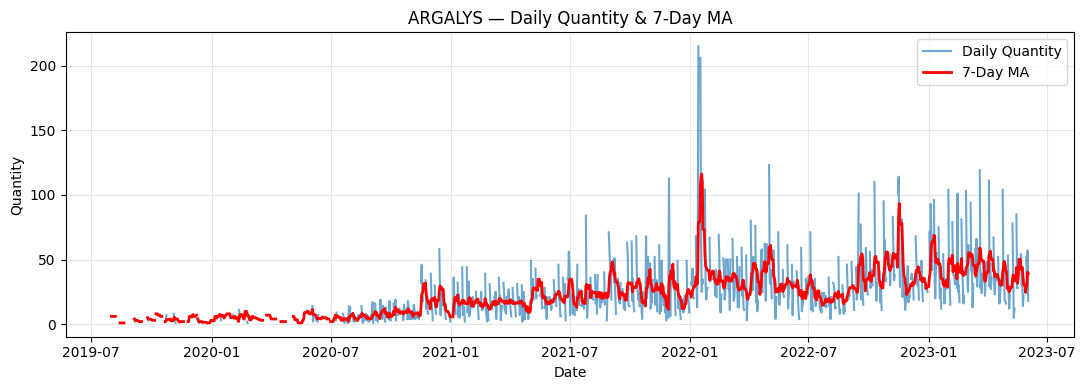

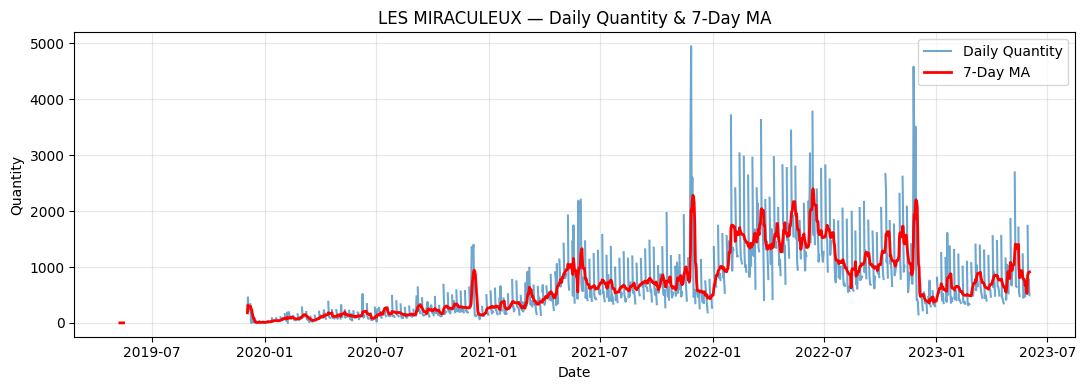

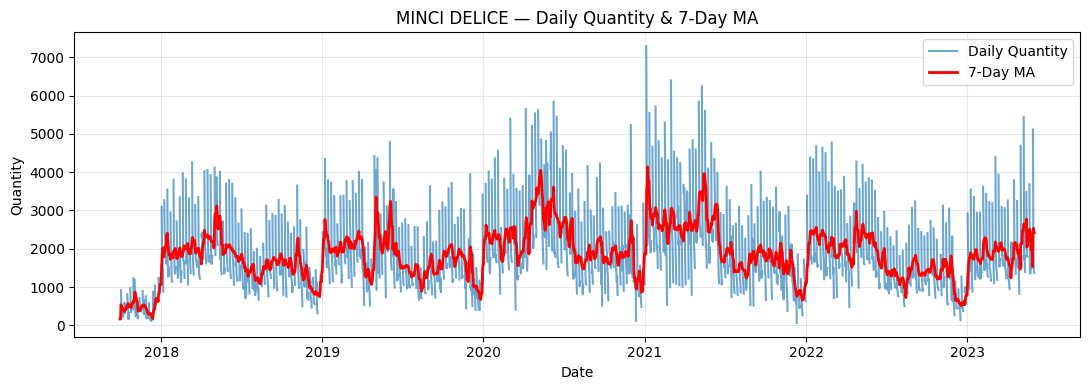

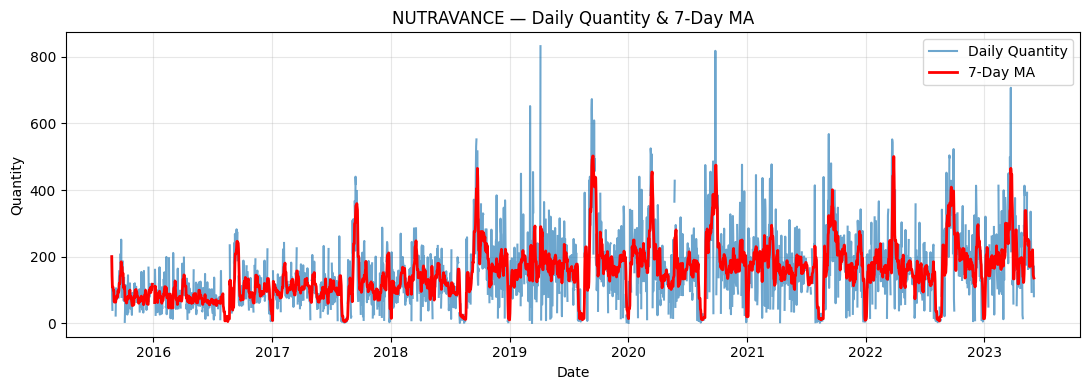

In [21]:
for cust, g in df_daily.groupby("CUSTOMER"):
    g = g.set_index("DATE").asfreq("D")
    g["7D_MA"] = g["QUANTITY"].rolling(7, min_periods=1).mean()

    plt.figure(figsize=(11,4))
    plt.plot(g.index, g["QUANTITY"], alpha=0.65, label="Daily Quantity")
    plt.plot(g.index, g["7D_MA"], linewidth=2, color= 'red', label="7-Day MA")
    plt.title(f"{cust} — Daily Quantity & 7-Day MA")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_timeseries.png", dpi=150)

# Seasonal Plots

In [30]:
sns.set_style("whitegrid")

In [22]:
def add_calendar_columns(df):
    df["Month"] = df["DATE"].dt.month
    df["DayOfWeek"] = df["DATE"].dt.dayofweek  # 0=Mon,6=Sun
    df["DayOfMonth"] = df["DATE"].dt.day
    return df

df_season = add_calendar_columns(df_daily.copy())

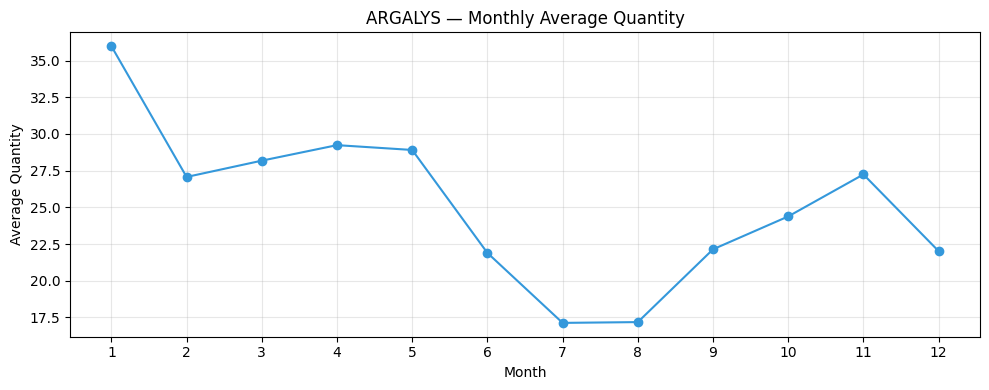

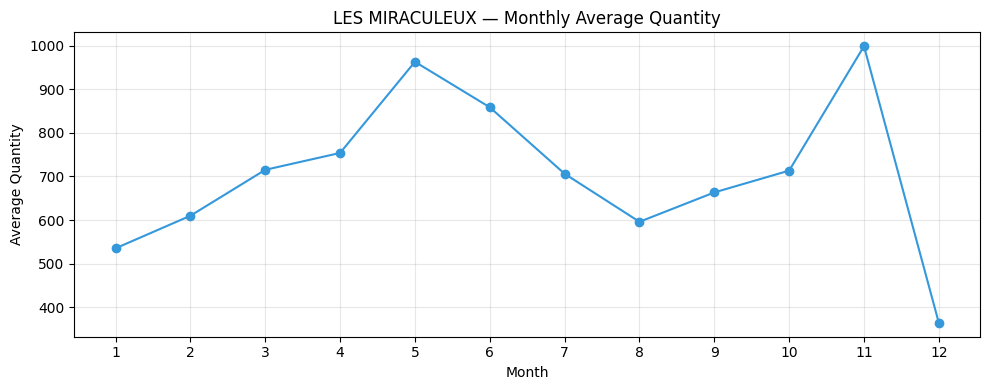

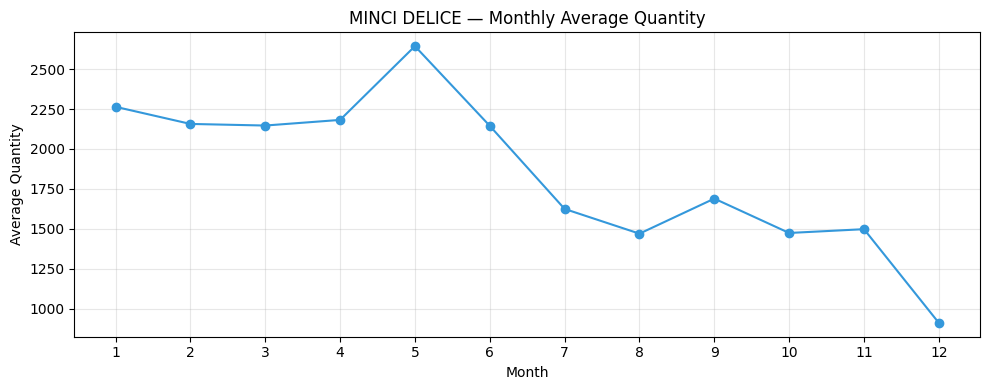

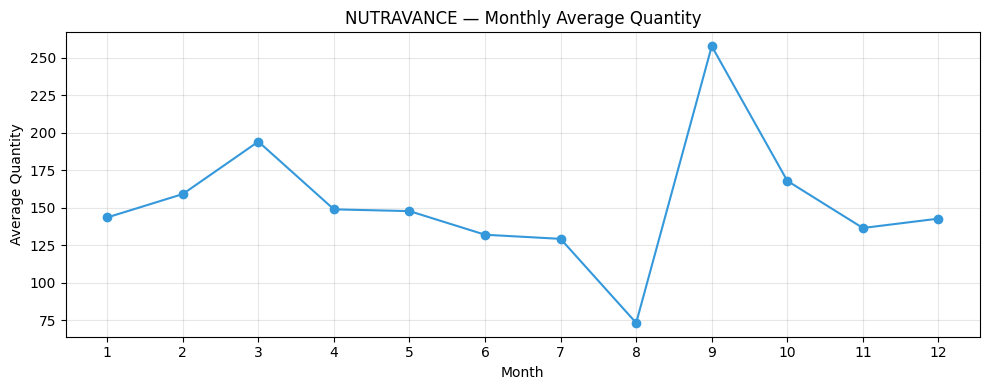

In [24]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    monthly = g.groupby("Month")["QUANTITY"].mean()
    plt.plot(monthly.index, monthly.values, marker='o', color="#3498DB")
    plt.title(f"{cust} — Monthly Average Quantity")
    plt.xlabel("Month")
    plt.ylabel("Average Quantity")
    plt.xticks(range(1,13))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_seasonal_monthly.png", dpi=150)

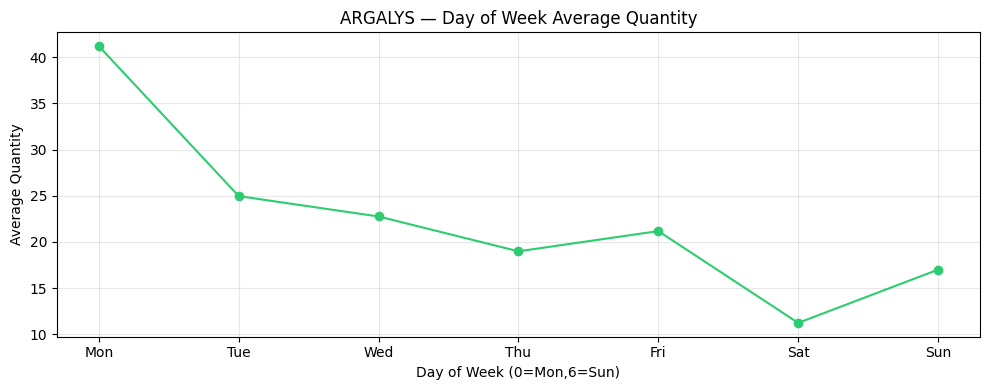

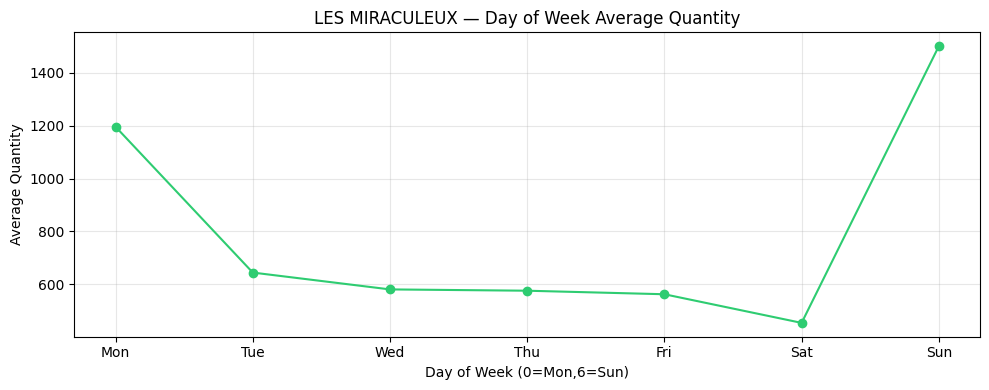

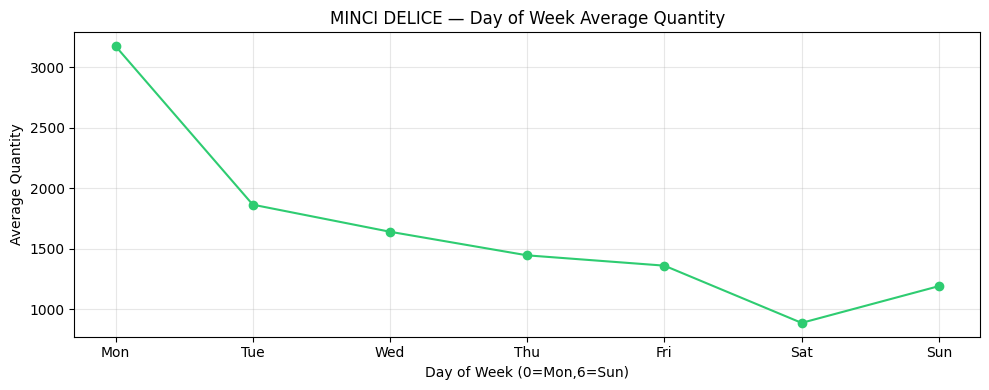

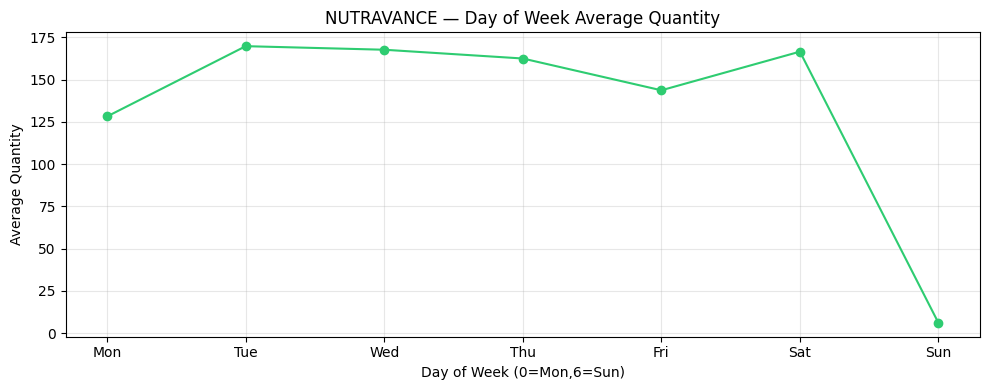

In [25]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    dow = g.groupby("DayOfWeek")["QUANTITY"].mean()
    plt.plot(dow.index, dow.values, marker='o', color="#2ECC71")
    plt.title(f"{cust} — Day of Week Average Quantity")
    plt.xlabel("Day of Week (0=Mon,6=Sun)")
    plt.ylabel("Average Quantity")
    plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_seasonal_dow.png", dpi=150)

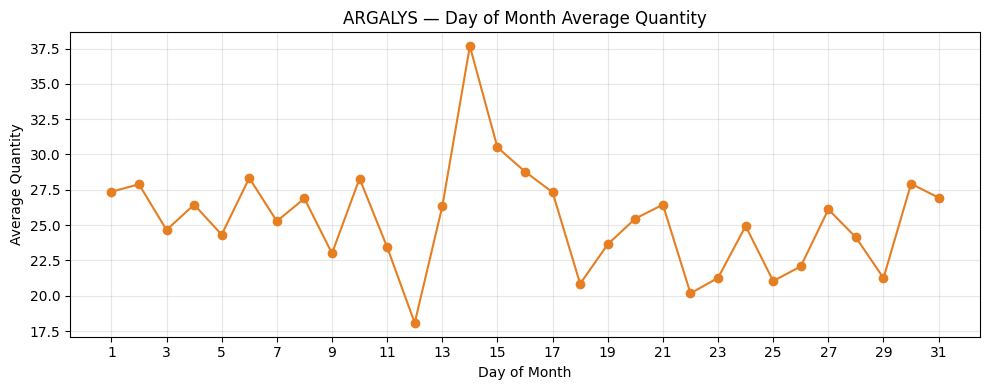

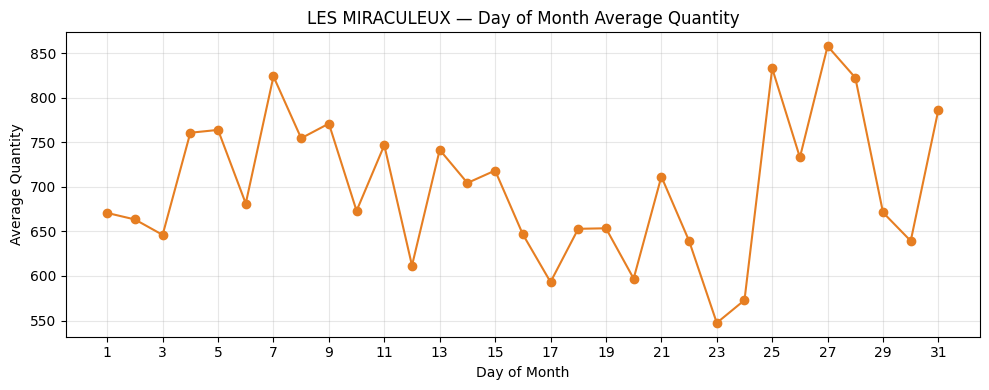

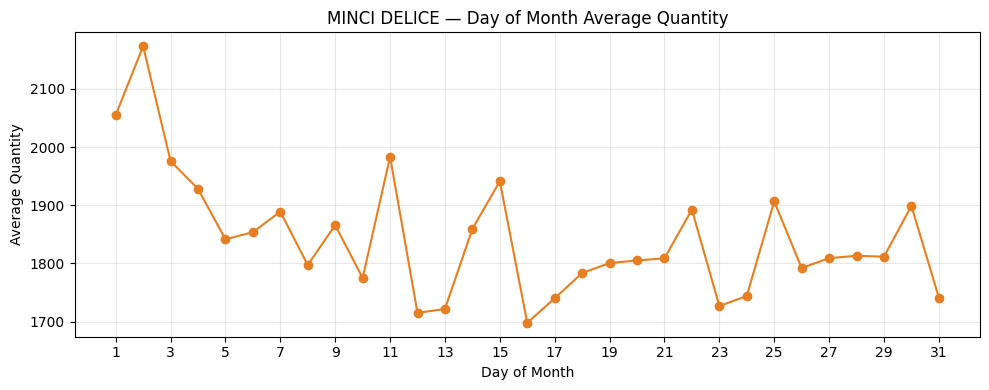

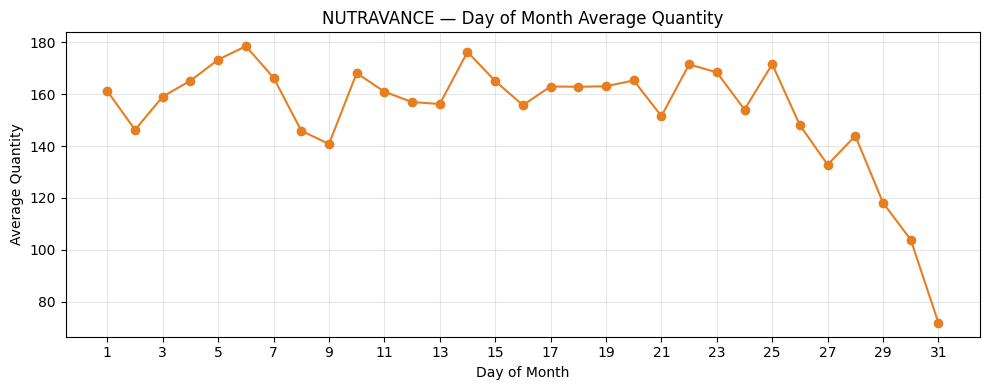

In [26]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    dom = g.groupby("DayOfMonth")["QUANTITY"].mean()
    plt.plot(dom.index, dom.values, marker='o', color="#E67E22")
    plt.title(f"{cust} — Day of Month Average Quantity")
    plt.xlabel("Day of Month")
    plt.ylabel("Average Quantity")
    plt.xticks(range(1,32,2))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_seasonal_dom.png", dpi=150)

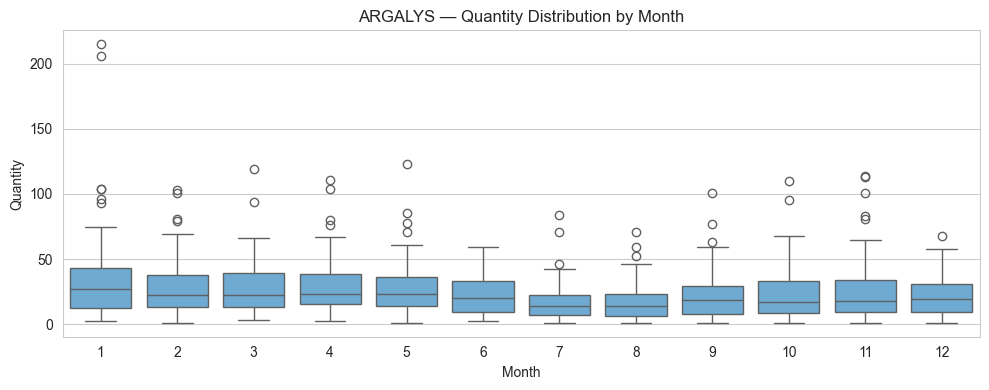

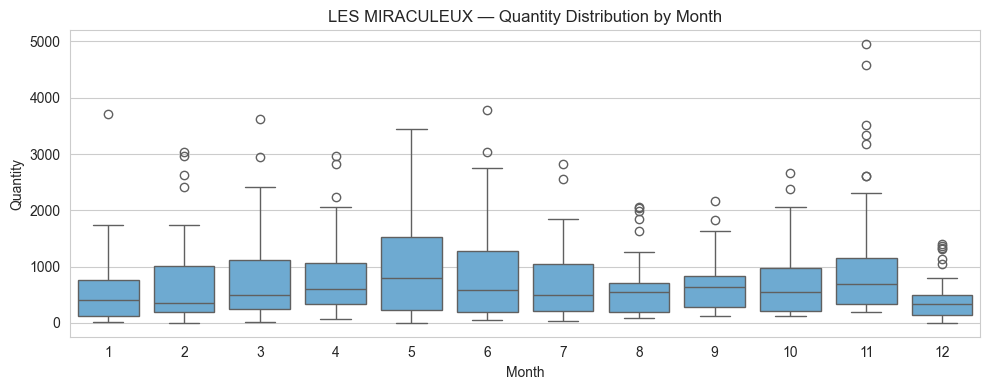

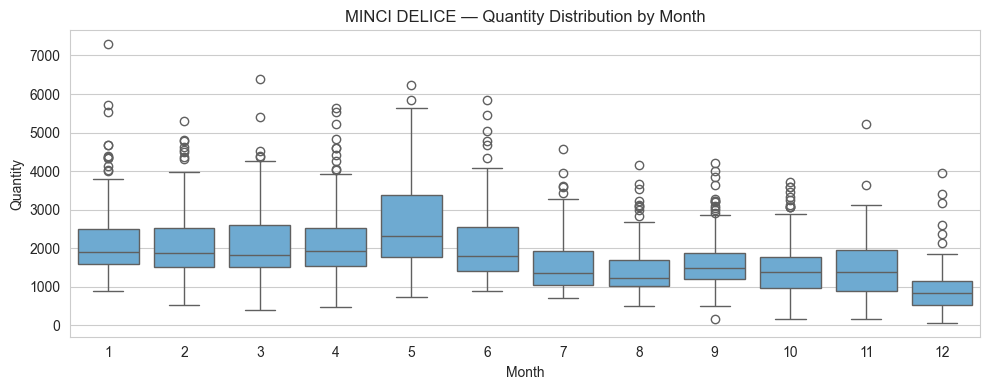

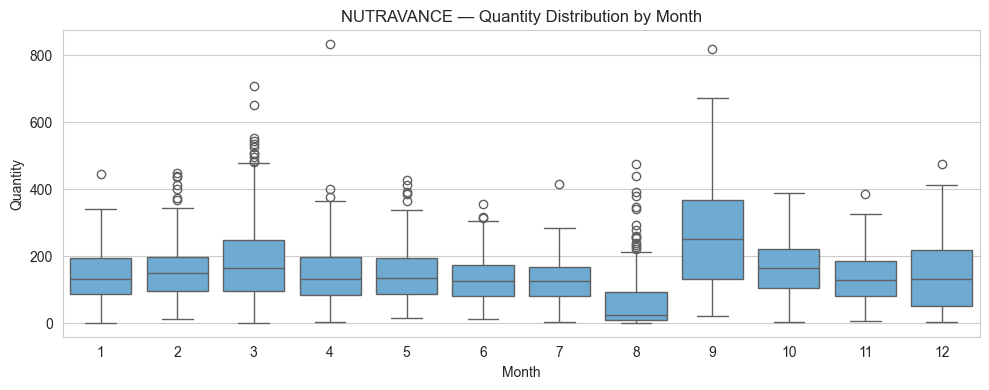

In [31]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    sns.boxplot(data=g, x="Month", y="QUANTITY", color="#5DADE2")
    plt.title(f"{cust} — Quantity Distribution by Month")
    plt.xlabel("Month")
    plt.ylabel("Quantity")
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_box_month.png", dpi=150)

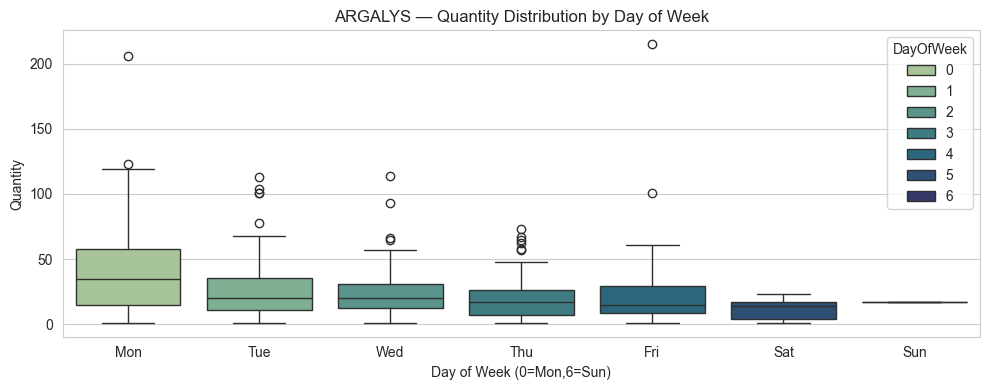

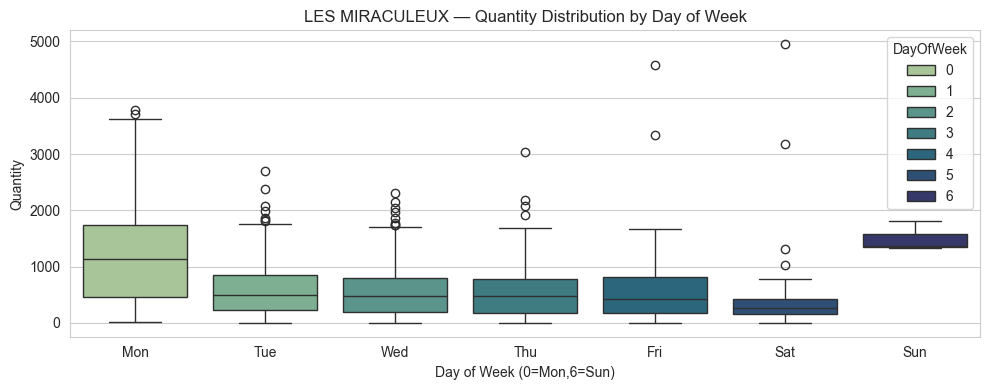

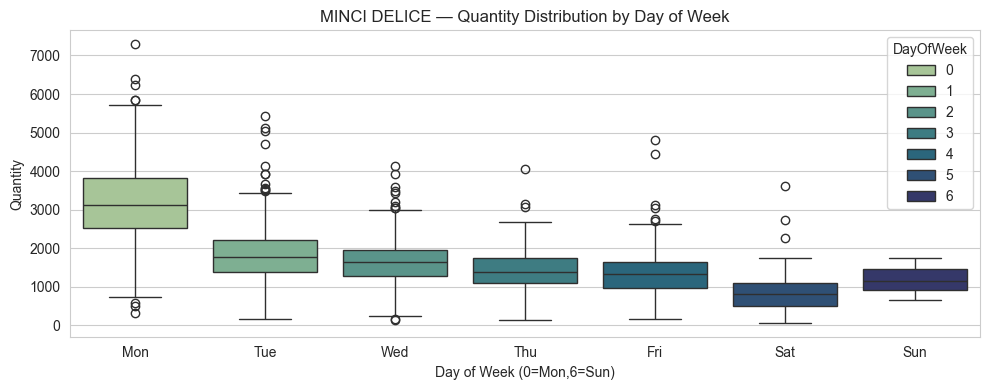

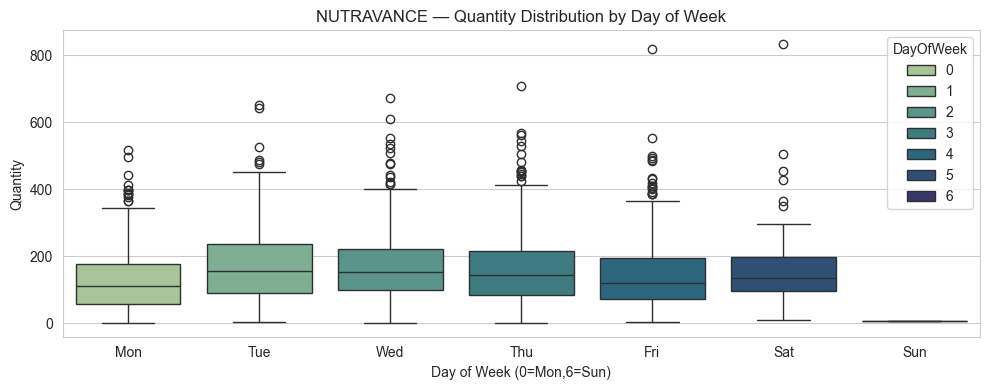

In [33]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    sns.boxplot(data=g, x="DayOfWeek", y="QUANTITY", palette="crest", hue = "DayOfWeek", )
    plt.title(f"{cust} — Quantity Distribution by Day of Week")
    plt.xlabel("Day of Week (0=Mon,6=Sun)")
    plt.ylabel("Quantity")
    plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_box_dow.png", dpi=150)

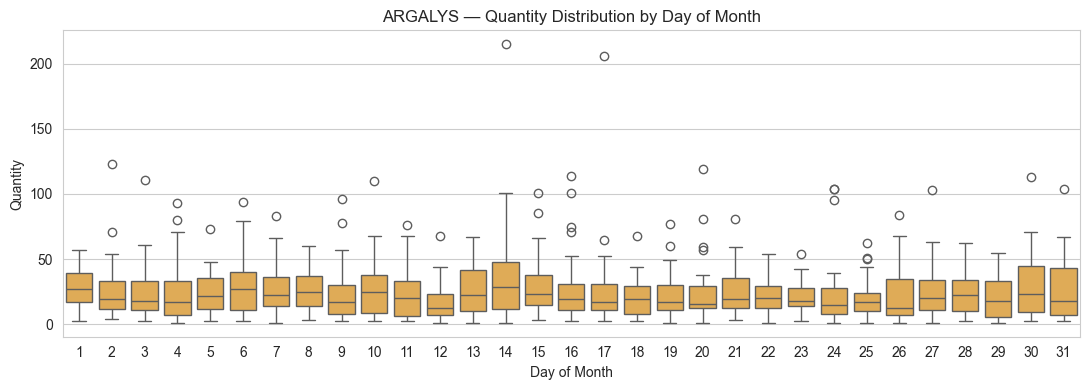

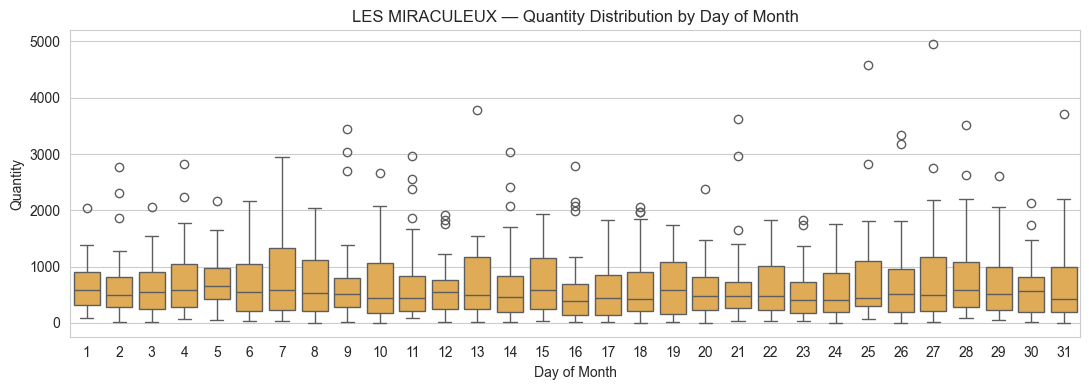

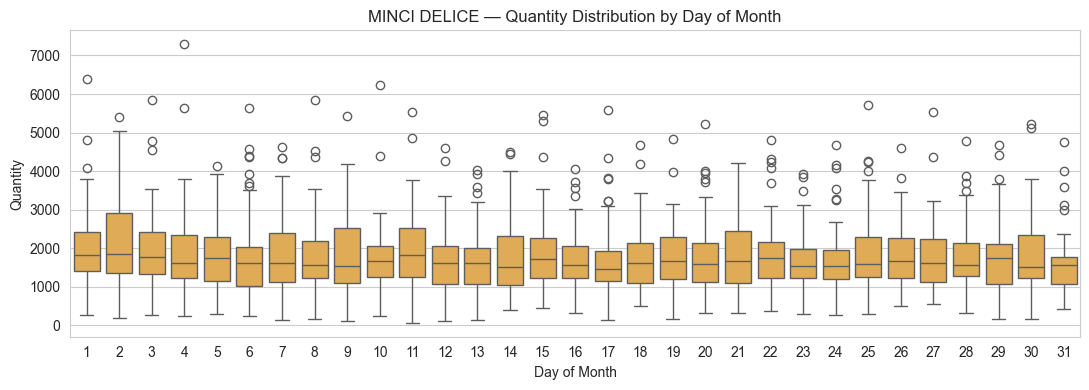

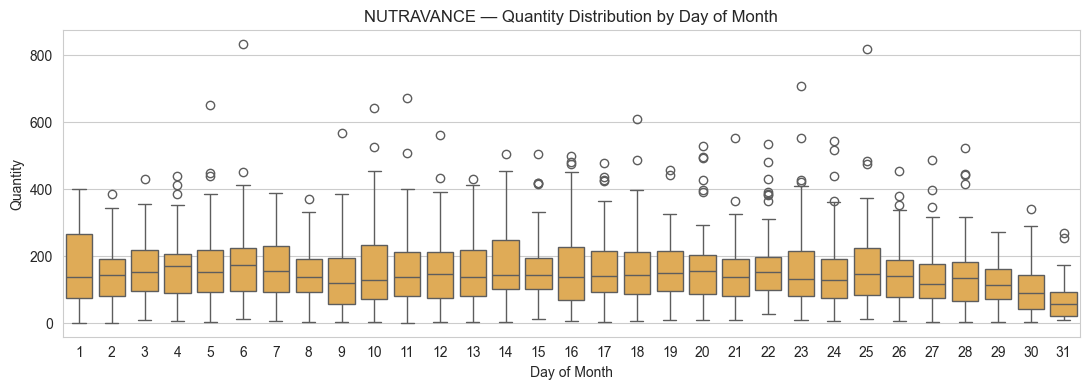

In [34]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(11,4))
    sns.boxplot(data=g, x="DayOfMonth", y="QUANTITY", color="#F5B041")
    plt.title(f"{cust} — Quantity Distribution by Day of Month")
    plt.xlabel("Day of Month")
    plt.ylabel("Quantity")
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_box_dom.png", dpi=150)

# STL Decomposition

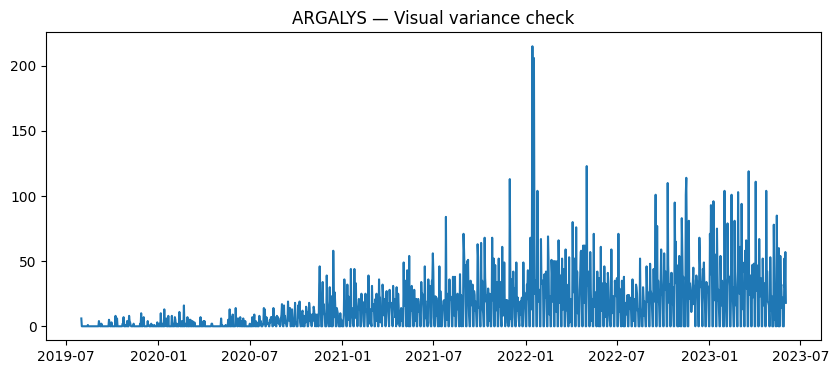

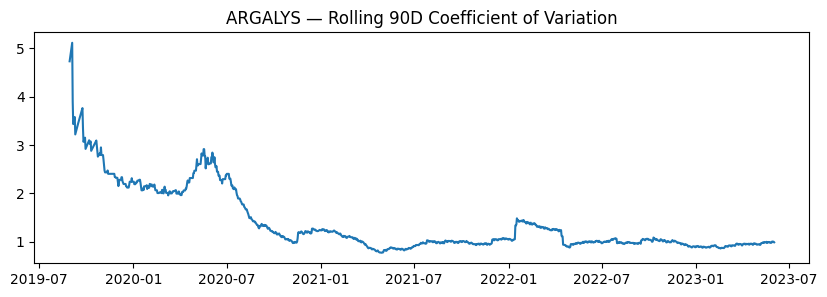

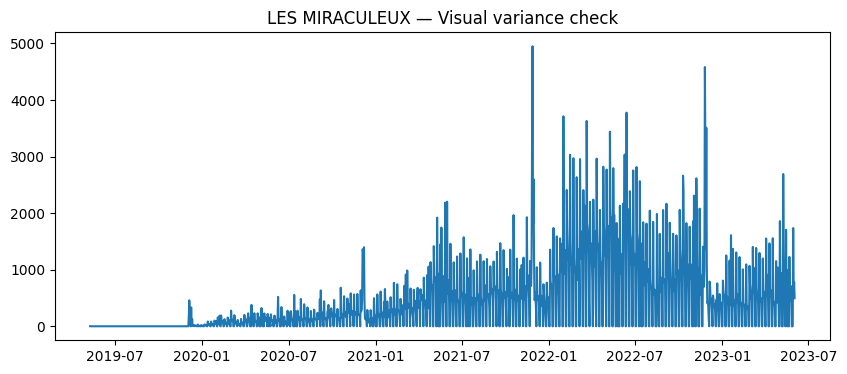

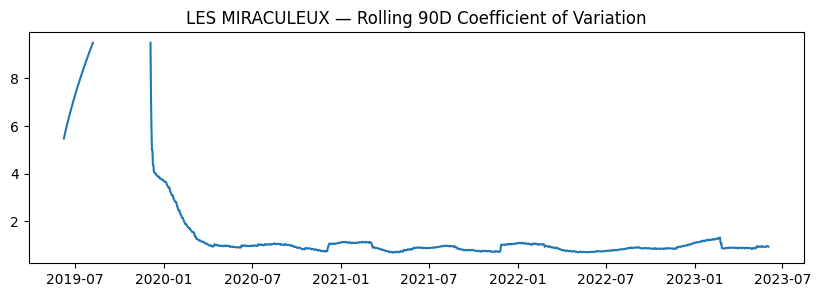

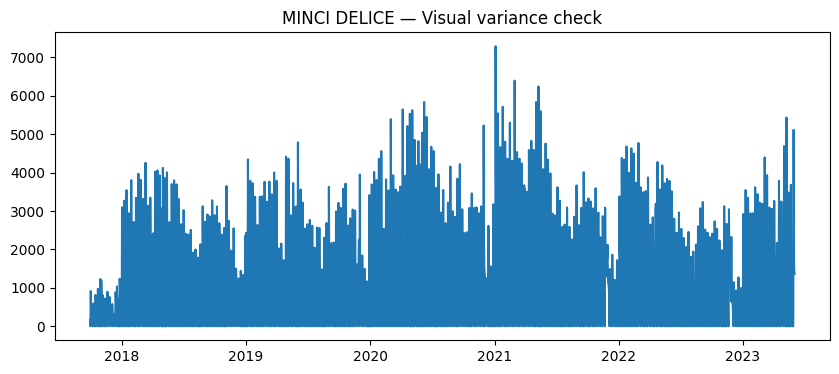

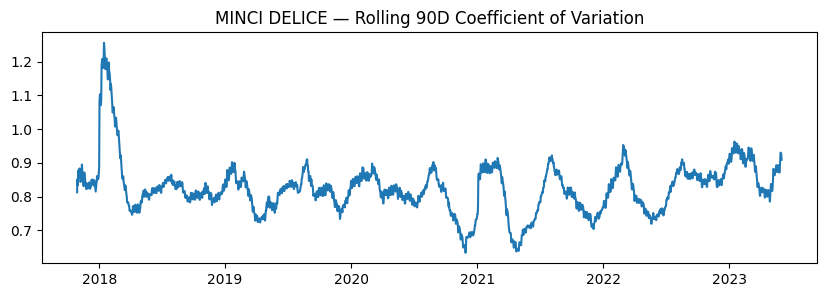

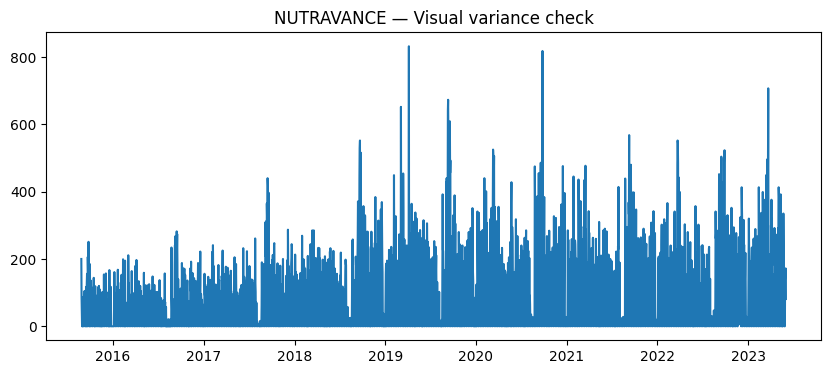

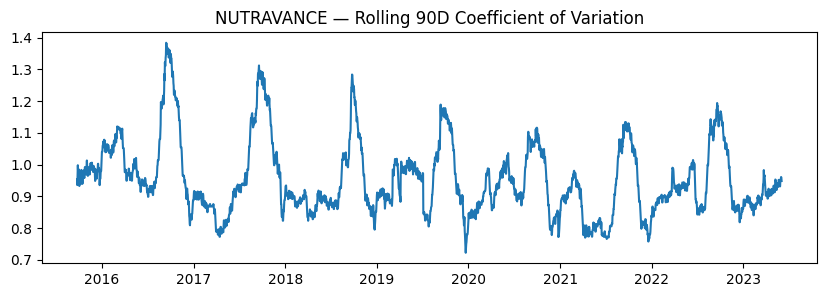

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

for cust, g in df_daily.groupby("CUSTOMER"):
    s = g.set_index("DATE").asfreq("D")["QUANTITY"].fillna(0)
    
    # visualize seasonality amplitude change
    plt.figure(figsize=(10,4))
    plt.plot(s)
    plt.title(f"{cust} — Visual variance check")
    plt.show()

    # quick rule of thumb: coefficient of variation over rolling windows
    roll_cv = s.rolling(90, min_periods=30).std() / s.rolling(90, min_periods=30).mean()
    plt.figure(figsize=(10,3))
    plt.plot(roll_cv)
    plt.title(f"{cust} — Rolling 90D Coefficient of Variation")
    plt.show()

In [14]:
cv_ratio = (s.tail(180).std()/s.tail(180).mean()) / (s.head(180).std()/s.head(180).mean())
print(f"{cust}: CV ratio (last 6m / first 6m) = {cv_ratio:.2f}")

NUTRAVANCE: CV ratio (last 6m / first 6m) = 0.89


ARGALYS → RelResid(Additive)=0.4497, RelResid(Multiplicative/log)=0.2573 → Best: multiplicative (log)
LES MIRACULEUX → RelResid(Additive)=0.4870, RelResid(Multiplicative/log)=0.1966 → Best: multiplicative (log)
MINCI DELICE → RelResid(Additive)=0.5458, RelResid(Multiplicative/log)=0.3928 → Best: multiplicative (log)
NUTRAVANCE → RelResid(Additive)=0.4981, RelResid(Multiplicative/log)=0.4153 → Best: multiplicative (log)


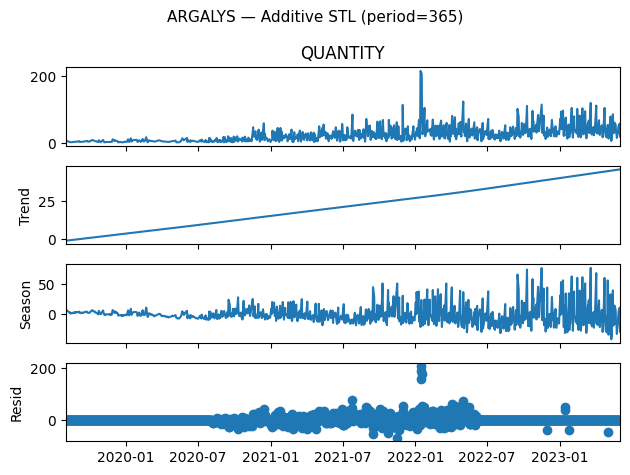

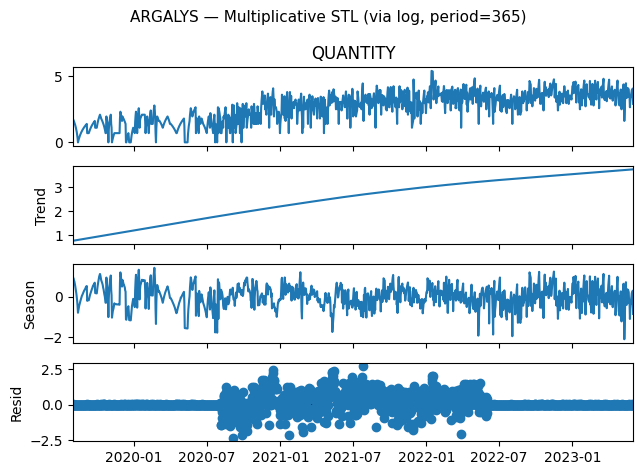

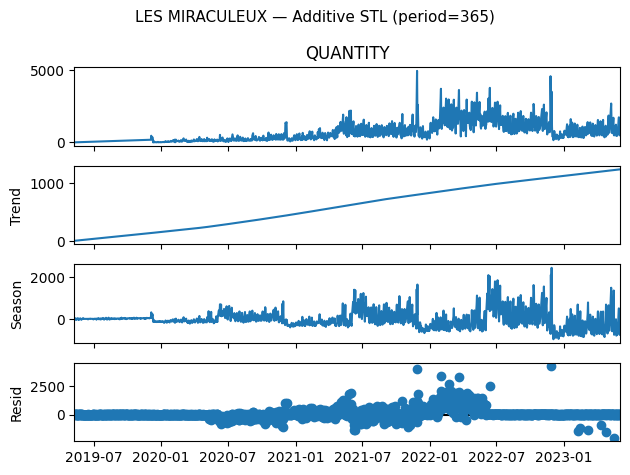

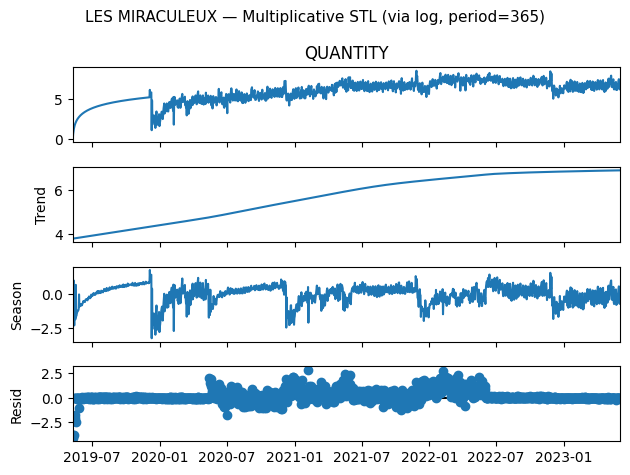

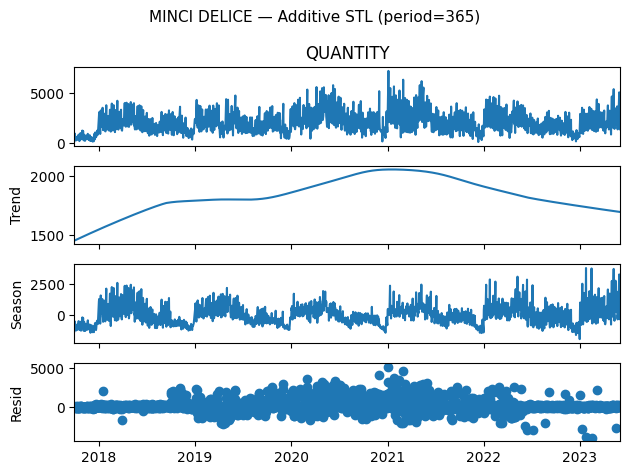

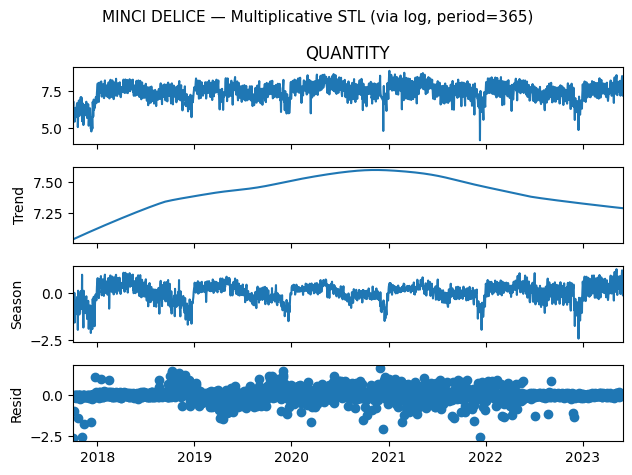

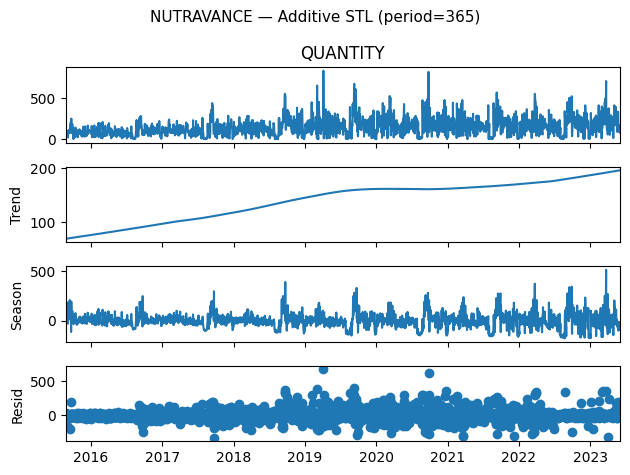

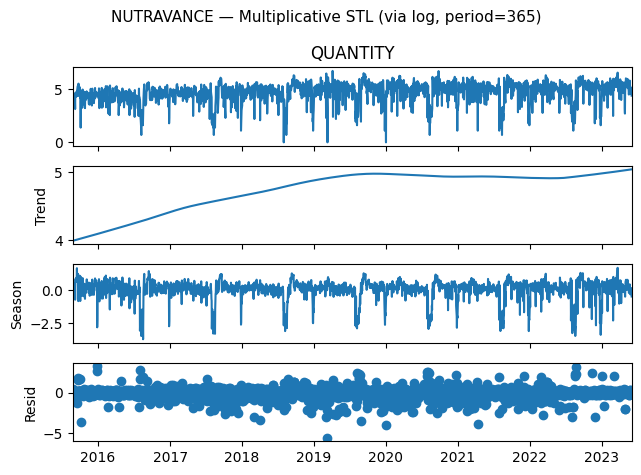

In [18]:
results = []

for cust, g in df_daily.groupby("CUSTOMER"):
    # 1) Build daily series
    s = g.set_index("DATE").asfreq("D")["QUANTITY"]

    # 2) Prepare series for decomposition
    #    - interpolate for gaps (keeps shape similar for fair comparison)
    s_add = s.interpolate(method="time", limit_direction="both")
    # multiplicative: log requires strictly positive values
    s_pos = s.replace(0, np.nan)
    s_mul = s_pos.interpolate(method="time", limit_direction="both")

    # If too short or all NaNs, skip cleanly
    if s_add.dropna().shape[0] < 14:  # arbitrary minimum length
        print(f"Skipping {cust}: not enough data after interpolation.")
        continue

    # 3) Additive STL (original scale)
    res_add = STL(s_add.fillna(0), period=365, robust=True).fit()
    fig_add = res_add.plot()
    fig_add.suptitle(f"{cust} — Additive STL (period=365)", fontsize=11)
    fig_add.tight_layout()

    # 4) Multiplicative STL (log scale)
    # If still any non-positive after interpolation, nudge a tiny epsilon
    s_mul = s_mul.copy()
    if (s_mul <= 0).any():
        s_mul = s_mul.mask(s_mul <= 0, np.nan).interpolate(method="time", limit_direction="both")
        # final fallback (very rare): add tiny epsilon
        s_mul = s_mul.fillna(s_mul.median()).clip(lower=1e-6)

    s_log = np.log(s_mul)
    res_mul = STL(s_log, period=365, robust=True).fit()
    fig_mul = res_mul.plot()
    fig_mul.suptitle(f"{cust} — Multiplicative STL (via log, period=365)", fontsize=11)
    fig_mul.tight_layout()

    # 5) Residual variance comparison
    #    - Additive: variance on original scale
    #    - Multiplicative: variance on log scale (natural for multiplicative)
    var_y_add = np.nanvar(s_add)
    var_res_add = np.nanvar(res_add.resid)
    rel_add = var_res_add / var_y_add if var_y_add > 0 else np.nan

    var_y_log = np.nanvar(s_log)
    var_res_mul = np.nanvar(res_mul.resid)
    rel_mul = var_res_mul / var_y_log if var_y_log > 0 else np.nan

    better = "multiplicative (log)" if (np.nan_to_num(rel_mul, nan=np.inf) < np.nan_to_num(rel_add, nan=np.inf)) else "additive"

    results.append({
        "Customer": cust,
        "VarResid_Add": float(var_res_add),
        "VarY_Add": float(var_y_add),
        "RelResid_Add": float(rel_add),
        "VarResid_MulLog": float(var_res_mul),
        "VarY_Log": float(var_y_log),
        "RelResid_MulLog": float(rel_mul),
        "Better_Decomposition": better
    })

    print(
        f"{cust} → "
        f"RelResid(Additive)={rel_add:.4f}, "
        f"RelResid(Multiplicative/log)={rel_mul:.4f} → Best: {better}"
    )

In [19]:
# 6) Save comparison table
comp_df = pd.DataFrame(results).sort_values("Customer")
comp_df

,Customer,VarResid_Add,VarY_Add,RelResid_Add,VarResid_MulLog,VarY_Log,RelResid_MulLog,Better_Decomposition
0,ARGALYS,243.410706,541.262068,0.449710,0.319285,1.241002,0.257280,multiplicative (log)
1,LES MIRACULEUX,208458.065838,428086.154336,0.486954,0.336863,1.713812,0.196558,multiplicative (log)
2,MINCI DELICE,544405.871585,997434.803115,0.545806,0.128927,0.328261,0.392757,multiplicative (log)
3,NUTRAVANCE,5115.881067,10271.693558,0.498056,0.340046,0.818709,0.415344,multiplicative (log)
